In [20]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt

import wandb
!wandb login 1b8e8dc9dcf1a34397a04197c4826d3fe7441dae
api = wandb.Api()

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [21]:
def get_runs(project, api=api):
    runs = api.runs(project)
    summary_list, config_list, name_list = [], [], []
    for run in runs:
        summary_list.append(run.summary._json_dict)
        config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})
        name_list.append(run.name)
    
    runs_df = pd.DataFrame(
        {"summary": summary_list, "config": config_list, "name": name_list}
    )
    return runs_df

In [22]:
def plot_se(x, y, y_se, label=None):
    plt.plot(x, y, label=label, marker=".")
    plt.fill_between(x, y - y_se, y + y_se, alpha=0.3)

# Finetune

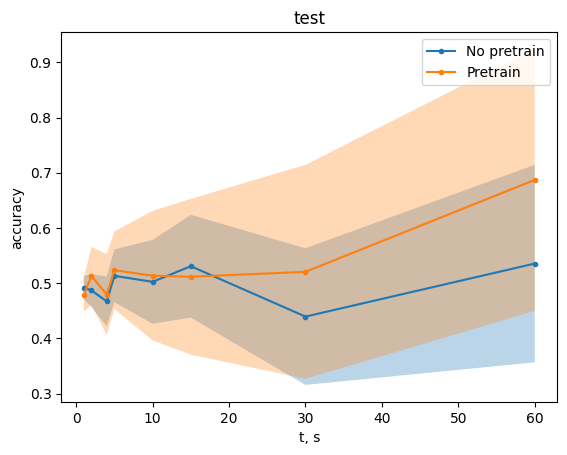

In [23]:
runs_df = get_runs("dmitriykornilov_team/EEG_depression_classification")
results = []

for idx, run in runs_df.iterrows():
    description = run['config']['model']['model_description']
    if 'finetune, duration' in description or 'duration, inhouse_dataset' in description:
        results.append({
            "t": run['config']['dataset']['samples_shape'][1]/128,
            "accuracy": run['summary']['final']['clf.d.test.accuracy.bs'],
            "accuracy_se": run['summary']['final']['clf.d.test.accuracy.se.bs'],
            'pretrain': True if 'finetune, duration' in description else False
        })
    
results = pd.DataFrame.from_records(results)
for idx, df in results.groupby('pretrain'): plot_se(df['t'], df['accuracy'], df['accuracy_se'], label="Pretrain" if idx else "No pretrain")
plt.xlabel("t, s")
plt.ylabel("accuracy")
plt.title("test")
plt.legend()

# Recording length

In [162]:
runs_df = get_runs("dmitriykornilov_team/EEG_depression_classification")
results = {"dataset": [], "sample_len": [], "accuracy": [], "accuracy_se": []}

for idx, run in runs_df.iterrows():
    if 'test' in run['summary'] and 'dataset' in run['config'] and 'dataset' in run['config']['dataset']: #run was finished
        results['dataset'].append(run['config']['dataset']['dataset'])
        results['sample_len'].append(run['config']['dataset']['samples_shape'][-1])
        results['accuracy'].append(run['summary']['test']['clf.cv.test.accuracy.cv'])
        results['accuracy_se'].append(run['summary']['test']['clf.cv.test.accuracy.se.cv'])
results = pd.DataFrame(results)

results['sample length'] = results['sample_len']/128

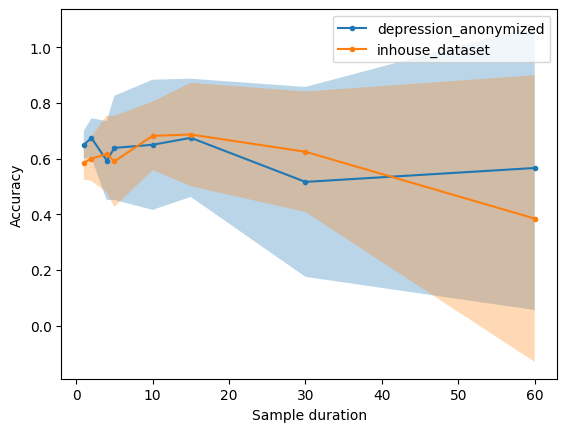

In [161]:
for idx, df in results.groupby("dataset"):
    plt.plot(df["sample length"], df["accuracy"], label=idx, marker=".")
    plt.fill_between(df["sample length"], df["accuracy"] - df["accuracy_se"], df["accuracy"] + df["accuracy_se"], alpha=0.3)
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Sample duration")
plt.show()

## Bootstrapping

In [275]:
runs_df = get_runs("dmitriykornilov_team/EEG_depression_classification")
results = {"dataset": [], "accuracy": [], "accuracy_se": [], "duration": []}

for idx, run in runs_df.iterrows():
    if 'duration' in run['name'] and 'test' in run['summary'] and 'clf.d.test.accuracy.bs' in run['summary']['test']:
        results['dataset'].append(run['config']['dataset']['train']['name'])
        results['duration'].append(float(run['config']['dataset']['train']['file'].split("_")[-1].split(".")[0]))
        results['accuracy'].append(run['summary']['test']['clf.d.test.accuracy.bs'])
        results['accuracy_se'].append(run['summary']['test']['clf.d.test.accuracy.se.bs'])
        
results = pd.DataFrame(results)
results = results.sort_values(['duration'])

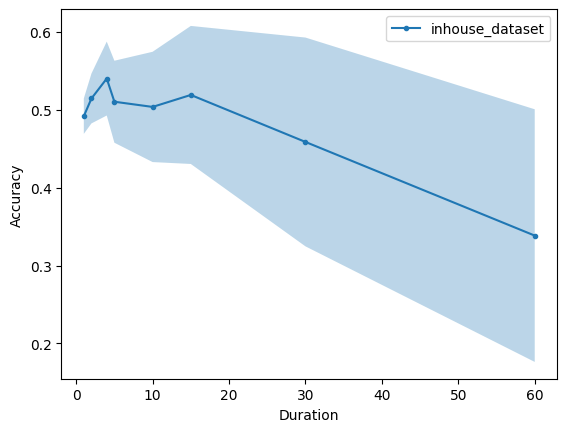

In [276]:
for idx, df in results.groupby("dataset"):
    plt.plot(df["duration"], df["accuracy"], label=idx, marker=".")
    plt.fill_between(df["duration"], df["accuracy"] - df["accuracy_se"], df["accuracy"] + df["accuracy_se"], alpha=0.3)
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Duration")
plt.show()

# Masking

## 1 s

In [146]:
runs_df = get_runs("dmitriykornilov_team/EEG_age_prediction")
results = {"dataset": [], "mask_ratio": [], "accuracy": []}

for idx, run in runs_df.iterrows():
    if 'masking' in run['config'] and \
    "mask_ratio" in run['config']['masking'] and \
    run['config']['masking']['mask_ratio'] >= 0.25 and \
    run['config']['samples_shape'][1] == 128: #and \
    # 'test' in run['summary']:
        results['dataset'].append(run['config']['dataset'])
        results['mask_ratio'].append(run['config']['masking']['mask_ratio'] if 'no_mask' not in run['name'] else 0)
        results['accuracy'].append(run['summary']['test.clf_accuracy_test'])
results = pd.DataFrame(results)
results = results.sort_values('mask_ratio')
results

,dataset,mask_ratio,accuracy
3,depression anonymized,0.00,0.605042
0,depression anonymized,0.25,0.655462
2,depression anonymized,0.50,0.655462
1,depression anonymized,0.75,0.658263


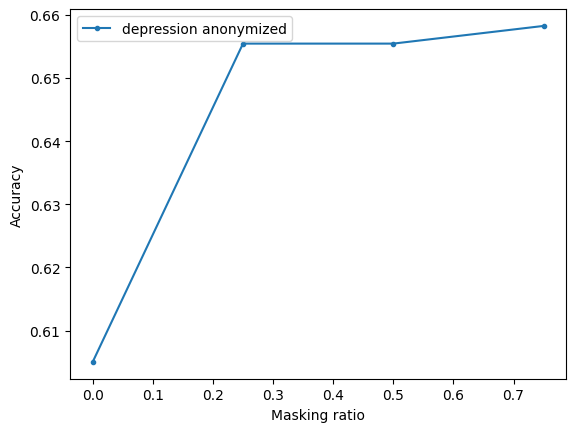

In [147]:
plt.plot(results['mask_ratio'], results['accuracy'], label=results['dataset'][0], marker=".")
plt.legend();
plt.xlabel("Masking ratio");
plt.ylabel("Accuracy");

## 10 s

In [211]:
runs_df = get_runs("dmitriykornilov_team/EEG_depression_classification")
results = {"dataset": [], "mask_ratio": [], "accuracy": [], "accuracy_se": []}

for idx, run in runs_df.iterrows():
    if (run['config']['train']['masking']['mask_ratio'] > 0 and 'test' in run['summary']):
        results['dataset'].append(run['config']['dataset']['train']['name'])
        results['mask_ratio'].append(run['config']['train']['masking']['mask_ratio'])
        results['accuracy'].append(run['summary']['test']['clf.cv.test.accuracy.cv'])
        results['accuracy_se'].append(run['summary']['test']['clf.cv.test.accuracy.se.cv'])

    if ('samples_shape' in run['config']['dataset'] and run['config']['dataset']['samples_shape'] == [3, 1280]):
        results['dataset'].append(run['config']['dataset']['dataset'])
        results['mask_ratio'].append(run['config']['train']['masking']['mask_ratio'])
        results['accuracy'].append(run['summary']['test']['clf.cv.test.accuracy.cv'])
        results['accuracy_se'].append(run['summary']['test']['clf.cv.test.accuracy.se.cv'])
        
results = pd.DataFrame(results)
results = results.sort_values(['dataset', 'mask_ratio'])

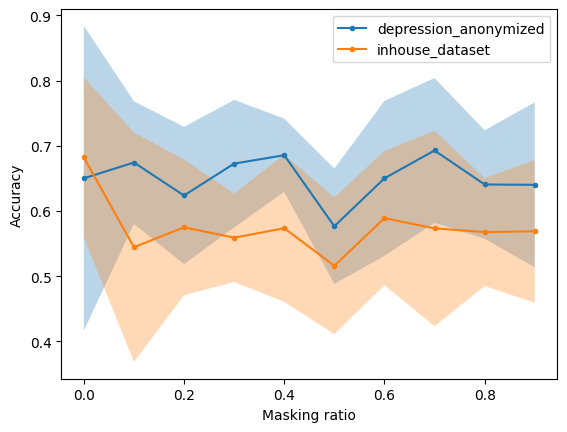

In [212]:
for idx, df in results.groupby("dataset"):
    plt.plot(df["mask_ratio"], df["accuracy"], label=idx, marker=".")
    plt.fill_between(df["mask_ratio"], df["accuracy"] - df["accuracy_se"], df["accuracy"] + df["accuracy_se"], alpha=0.3)
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Masking ratio")
plt.show()

## Bootstrapping

In [247]:
runs_df = get_runs("dmitriykornilov_team/EEG_depression_classification")
results = {"dataset": [], "mask_ratio": [], "accuracy": [], "accuracy_se": [], "duration": []}

for idx, run in runs_df.iterrows():
    if 'masking' in run['name'] and 'test' in run['summary'] and 'clf.d.test.accuracy.bs' in run['summary']['test']:
        results['dataset'].append(run['config']['dataset']['train']['name'])
        results['duration'].append(run['config']['dataset']['train']['file'].split("_")[-1].split(".")[0])
        results['mask_ratio'].append(run['config']['train']['masking']['mask_ratio'])
        results['accuracy'].append(run['summary']['test']['clf.d.test.accuracy.bs'])
        results['accuracy_se'].append(run['summary']['test']['clf.d.test.accuracy.se.bs'])
        
results = pd.DataFrame(results)
results = results.sort_values(['duration', 'mask_ratio'])

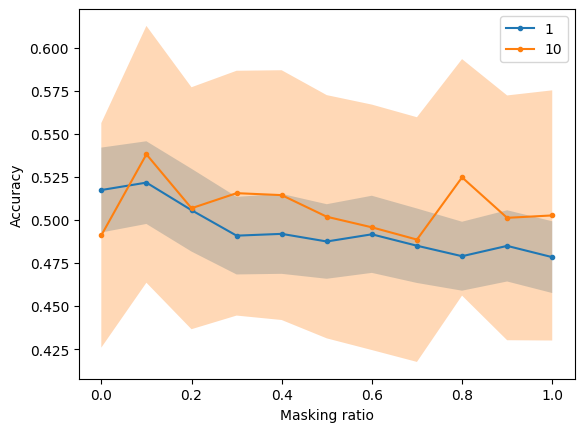

In [248]:
for idx, df in results.groupby("duration"):
    plt.plot(df["mask_ratio"], df["accuracy"], label=idx, marker=".")
    plt.fill_between(df["mask_ratio"], df["accuracy"] - df["accuracy_se"], df["accuracy"] + df["accuracy_se"], alpha=0.3)
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Masking ratio")
plt.show()

# Loss type

## 1 s

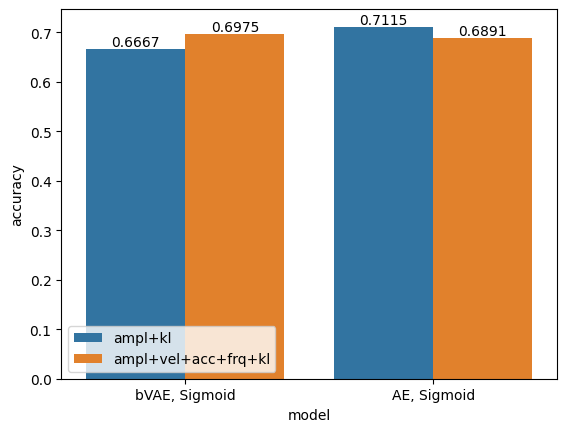

In [166]:
import seaborn as sns

results = pd.DataFrame.from_records([
    {
        'model': 'bVAE, Sigmoid',
        'loss': 'ampl+kl',
        'accuracy': 0.6667
    },
    {
        'model': 'bVAE, Sigmoid',
        'loss': 'ampl+vel+acc+frq+kl',
        'accuracy': 0.6975
    },
    {
        'model': 'AE, Sigmoid',
        'loss': 'ampl+kl',
        'accuracy': 0.7115
    },
    {
        'model': 'AE, Sigmoid',
        'loss': 'ampl+vel+acc+frq+kl',
        'accuracy': 0.6891
    },
])

ax = sns.barplot(results, x='model', y='accuracy', hue='loss');
ax.bar_label(ax.containers[0], fontsize=10);
ax.bar_label(ax.containers[1], fontsize=10);
plt.legend(loc='lower left');

## 10 s

In [252]:
def coefs_to_tag(coefs):
    name = ""
    for component, value in coefs.items():
        if value == 1 and component != "kl":
            name = component + "+" + name
    name = name[:-1]
    return name

In [231]:
runs_df = get_runs("dmitriykornilov_team/EEG_depression_classification")
results = {"dataset": [], "loss_coefs": [], "accuracy": [], "accuracy_se": []}

for idx, run in runs_df.iterrows():
    if 'coefs' in run['name']:
        results['dataset'].append(run['config']['dataset']['train']['name'])
        results['loss_coefs'].append(coefs_to_tag(run['config']['train']['loss_coefs']))
        results['accuracy'].append(run['summary']['test']['clf.cv.test.accuracy.cv'])
        results['accuracy_se'].append(run['summary']['test']['clf.cv.test.accuracy.se.cv'])
        
results = pd.DataFrame(results)
results = results.sort_values(['dataset'])
results

,dataset,loss_coefs,accuracy,accuracy_se
0,depression_anonymized,ampl+vel+frq+acc,0.646261,0.137158
1,depression_anonymized,frq,0.565688,0.131935
2,depression_anonymized,acc,0.634941,0.119043
3,depression_anonymized,vel,0.643990,0.153056
4,depression_anonymized,ampl,0.648113,0.123973
5,inhouse_dataset,ampl+vel+frq+acc,0.557433,0.064730
6,inhouse_dataset,frq,0.555942,0.098039
7,inhouse_dataset,acc,0.553251,0.117930
8,inhouse_dataset,vel,0.564658,0.118996
9,inhouse_dataset,ampl,0.558820,0.152852


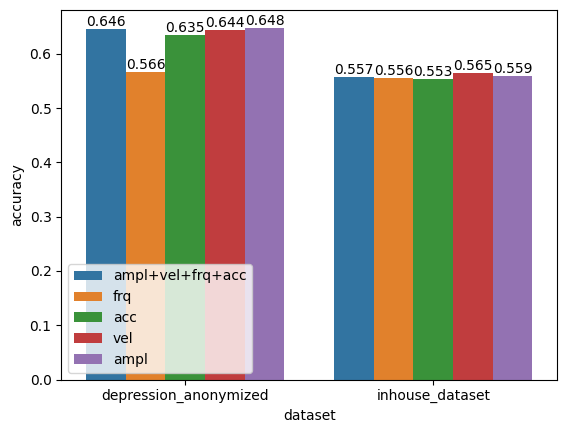

In [236]:
ax = sns.barplot(results, x='dataset', y='accuracy', hue='loss_coefs');
for container in ax.containers:
    ax.bar_label(container, fontsize=10, fmt='%.3f');

plt.legend(loc='lower left');

## Bootstrapping

In [265]:
runs_df = get_runs("dmitriykornilov_team/EEG_depression_classification")
results = {"dataset": [], "loss_coefs": [], "accuracy": [], "accuracy_se": [], "duration": []}

for idx, run in runs_df.iterrows():
    if 'coefs' in run['name'] and 'test' in run['summary'] and 'clf.d.test.accuracy.bs' in run['summary']['test']:
        results['dataset'].append(run['config']['dataset']['train']['name'])
        results['duration'].append(run['config']['dataset']['train']['file'].split("_")[-1].split(".")[0])
        results['loss_coefs'].append(coefs_to_tag(run['config']['train']['loss_coefs']))
        results['accuracy'].append(run['summary']['test']['clf.d.test.accuracy.bs'])
        results['accuracy_se'].append(run['summary']['test']['clf.d.test.accuracy.se.bs'])
        
results = pd.DataFrame(results)
results = results.sort_values(['duration'])
results

,dataset,loss_coefs,accuracy,accuracy_se,duration
5,inhouse_dataset,ampl+vel+frq+acc,0.503659,0.023603,1
6,inhouse_dataset,frq,0.515658,0.023484,1
7,inhouse_dataset,acc,0.518312,0.022938,1
8,inhouse_dataset,vel,0.517295,0.023687,1
9,inhouse_dataset,ampl,0.506702,0.023063,1
0,inhouse_dataset,ampl+vel+frq+acc,0.547467,0.076403,10
1,inhouse_dataset,frq,0.542482,0.075008,10
2,inhouse_dataset,acc,0.506116,0.072401,10
3,inhouse_dataset,vel,0.501656,0.071387,10
4,inhouse_dataset,ampl,0.508778,0.071721,10


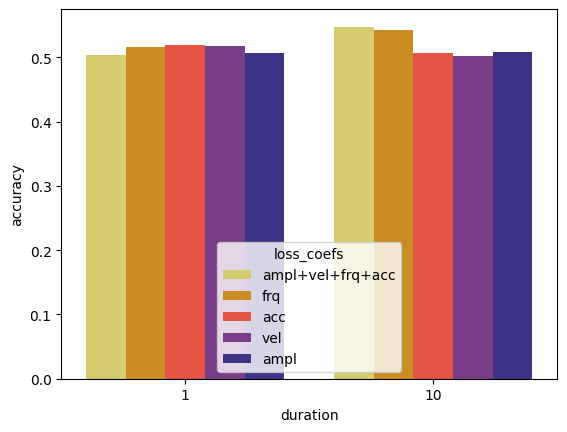

In [268]:
ax = sns.barplot(x='duration', y='accuracy', data=results, hue='loss_coefs', palette='CMRmap_r')
# x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
# y_coords = [p.get_height() for p in ax.patches]
# ax.errorbar(x=x_coords, y=y_coords, yerr=results["accuracy_se"], fmt="none", c="k")

# Convolutions kernel size

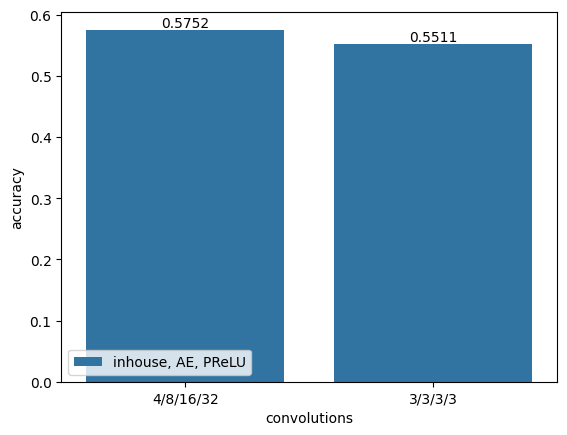

In [167]:
import seaborn as sns

results = pd.DataFrame.from_records([
    {
        'model': 'inhouse, AE, PReLU',
        "convolutions": "4/8/16/32",
        'accuracy': 0.5752
    },
    {
        'model': 'inhouse, AE, PReLU',
        "convolutions": "3/3/3/3",
        'accuracy': 0.5511
    },
])

ax = sns.barplot(results, x='convolutions', y='accuracy', hue='model');
ax.bar_label(ax.containers[0], fontsize=10);
plt.legend(loc='lower left');

# Depth

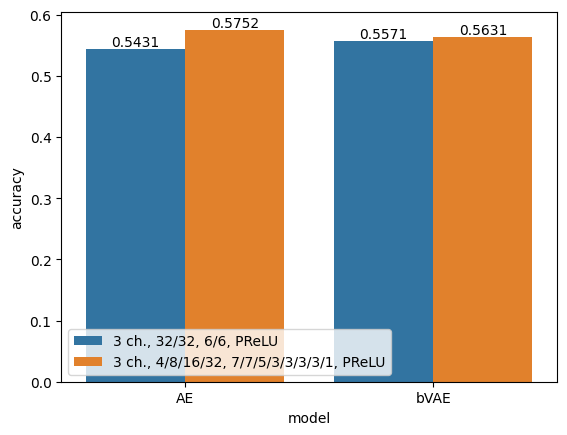

In [168]:
import seaborn as sns

results = pd.DataFrame.from_records([
    {
        'model': 'AE',
        'dataset': 'inhouse',
        'parameters': '3 ch., 32/32, 6/6, PReLU',
        'accuracy': 0.5431
    },
    {
        'model': 'bVAE',
        'dataset': 'inhouse',
        'parameters': '3 ch., 32/32, 6/6, PReLU',
        'accuracy': 0.5571
    },
    {
        'model': 'AE',
        'dataset': 'inhouse',
        'parameters': '3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, PReLU',
        'accuracy': 0.5752
    },
    {
        'model': 'bVAE',
        'dataset': 'inhouse',
        'parameters': '3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, PReLU',
        'accuracy': 0.5631
    },
])

ax = sns.barplot(results, x='model', y='accuracy', hue='parameters');
ax.bar_label(ax.containers[0], fontsize=10);
ax.bar_label(ax.containers[1], fontsize=10);
plt.legend(loc='lower left');